# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


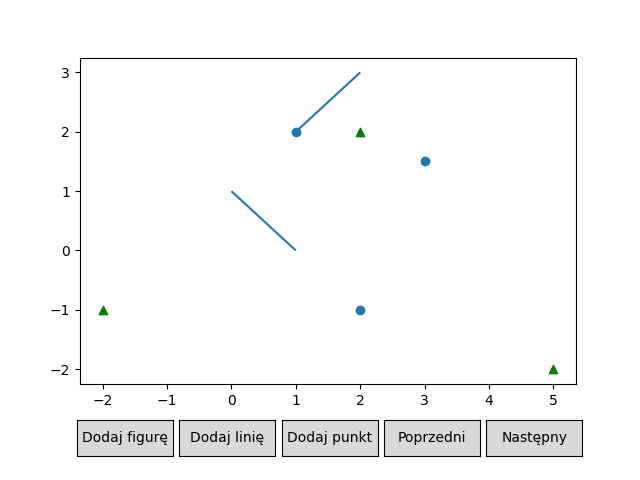

In [48]:
%matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


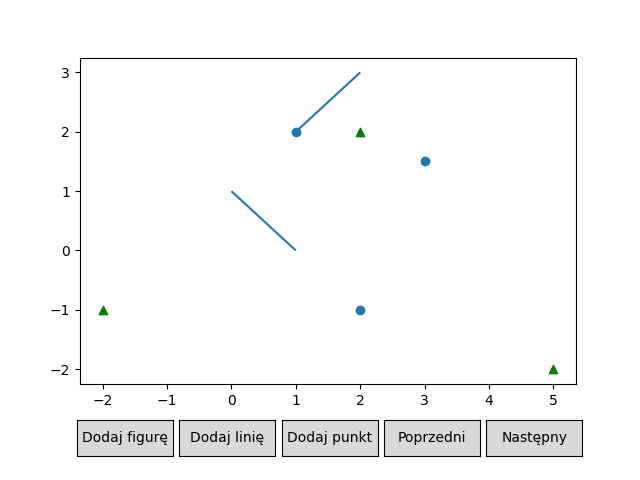

In [49]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


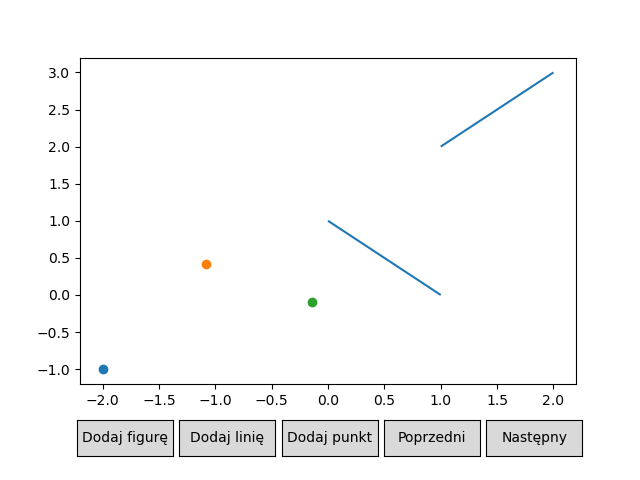

In [50]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


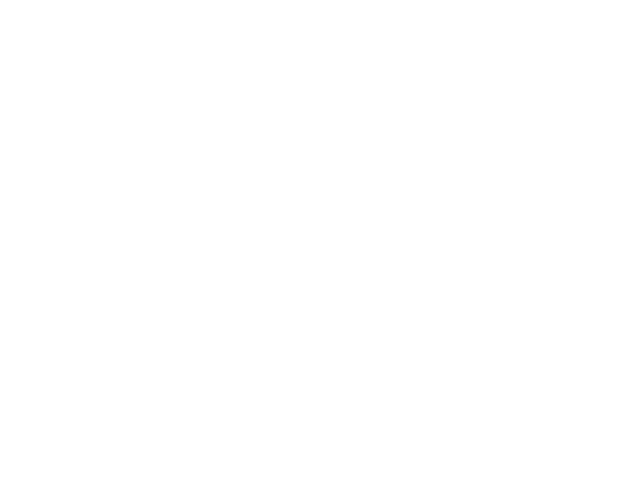

In [6]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


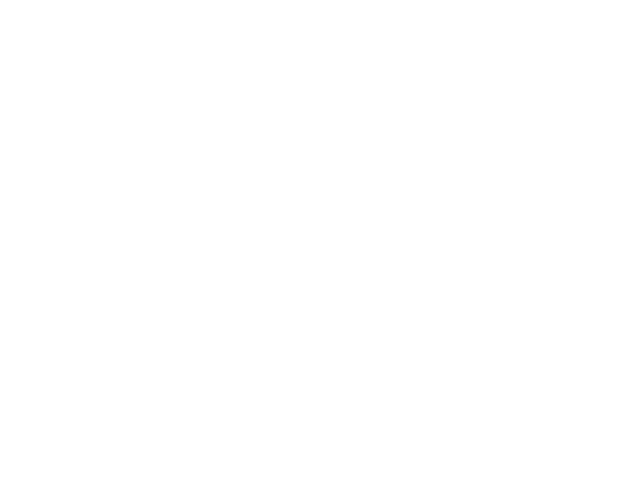

In [7]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

<hr style="border:2px solid gray">

# Rozwiązanie

#### Punkty wyznaczające wektor

In [8]:
A = (-1, 0)
B = (1, 0.1)

#### Własne implementacje wyznaczników

In [9]:
def det2x2(matrix):
    return matrix[0, 0] * matrix[1, 1] - matrix[0, 1] * matrix[1, 0]

def det3x3(matrix):
    return (matrix[0, 0] * matrix[1, 1] * matrix[2, 2] + 
            matrix[1, 0] * matrix[2, 1] * matrix[0, 2] + 
            matrix[2, 0] * matrix[0, 1] * matrix[1, 2] - 
            matrix[2, 0] * matrix[1, 1] * matrix[0, 2] - 
            matrix[1, 0] * matrix[0, 1] * matrix[2, 2] - 
            matrix[0, 0] * matrix[2, 1] * matrix[1, 2])

#### Stałe pomocnicze

In [10]:
DET2X2NP = 0
DET2X2 = 1
DET3X3NP = 2
DET3X3 = 3

tolerances = [10e-18, 10e-14, 10e-10]

<hr style="border:1px solid gray">

## Zestaw danych 1

<IPython.core.display.Javascript object>


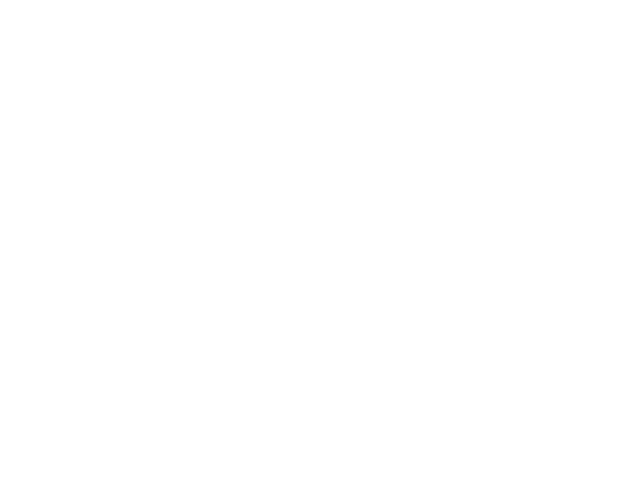

In [11]:
k = 10 ** 5
points1 = [None] * k
for i in range(k):
    x = random.uniform(-10 ** 3, 10 ** 3)
    y = random.uniform(-10 ** 3, 10 ** 3)
    points1[i] = (x, y)

plot = Plot(points=[PointsCollection(points1)])
plot.draw()

<hr style="border:1px solid gray">

## Zestaw danych 2

<IPython.core.display.Javascript object>


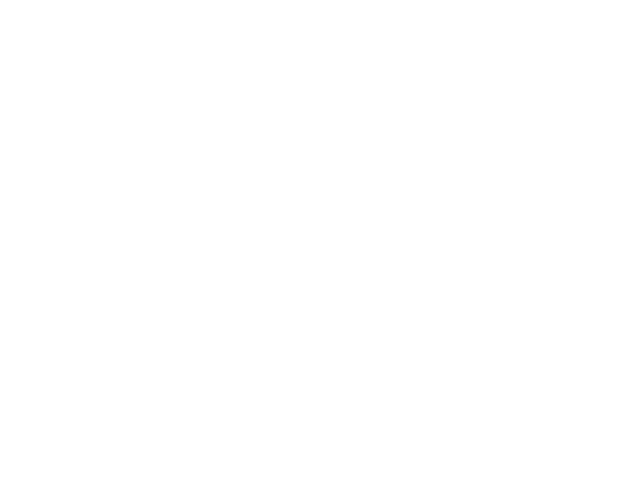

In [12]:
k = 10 ** 5
points2 = [None] * k
for i in range(k):
    x = random.uniform(-10 ** 14, 10 ** 14)
    y = random.uniform(-10 ** 14, 10 ** 14)
    points2[i] = (x, y)
    
plot = Plot(points=[PointsCollection(points2)])
plot.draw()

<hr style="border:1px solid gray">

## Zestaw danych 3

<IPython.core.display.Javascript object>


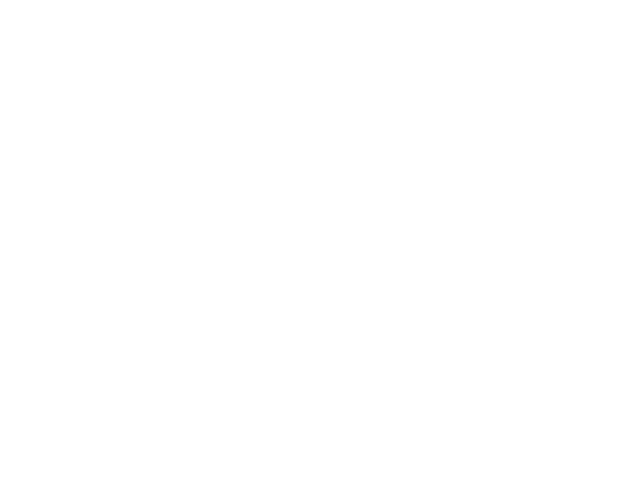

In [13]:
k = 10 ** 3
points3 = [None] * k
for i in range(k):
    a = random.uniform(0, 2*np.pi)
    x = np.cos(a)*100
    y = np.sin(a)*100
    points3[i] = (x, y)
    
plot = Plot(points=[PointsCollection(points3)])
plot.draw()

<hr style="border:1px solid gray">

## Zestaw danych 4

<IPython.core.display.Javascript object>


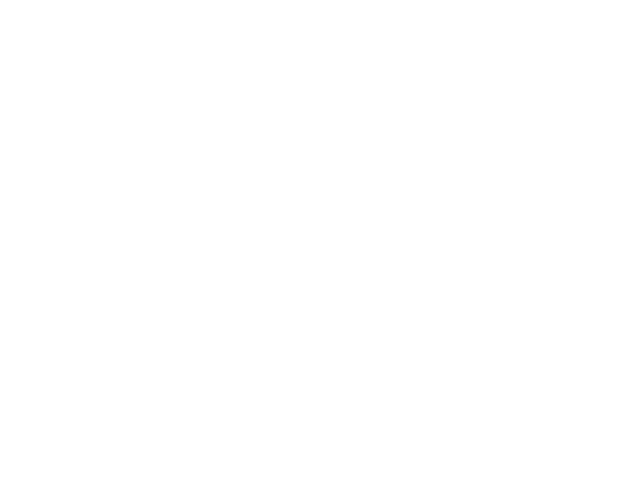

In [14]:
k = 10 ** 3
points4 = [None] * k
for i in range(k):
    a = (A[1] - B[1]) / (A[0] - B[0])
    b = A[1] - A[0] * a
    x = random.uniform(-10 ** 3, 10 ** 3)
    y = a * x + b
    points4[i] = (x, y)
           
plot = Plot(points=[PointsCollection(points4)])
plot.draw()

<hr style="border:1px solid gray">

## Kategoryzacja

Funkcja <i>categorize</i> przyjmuje tablicę punktów i dokonuje podziału ich położenia względem wektora [A,B].
Zwracana jest tablica trójwymiarowa*, gdzie:
- pierwszy indeks oznacza metodę obliczania wyznacznika
- drugi indeks oznacza użytą precyzję
- trzeci indeks oznacza kategorię podziału

np. results[1][2]['left'] oznacza punkty po lewej stronie lini wg. wyznacznika nr. 1 przy tolerancji nr. 2.

<font color='gray'>* tablica dwuwymiarowa, w której polach znajdują się słowniki</font>

In [15]:
def categorize(points):

    results = [[{'collinear':[], 'right':[], 'left':[]} for tolerance in range(3)] for det in range(4)]

    for point in points:
        # wyciągamy punkt i tworzymy dla niego macierze
        x = point[0]
        y = point[1]
        matrix3x3 = np.array([[A[0], A[1], 1], [B[0], B[1], 1], [x, y, 1]])
        matrix2x2 = np.array([[A[0] - x, A[1] - y], [B[0] - x, B[1] - y]])
        # liczymy wyznaczniki w kolejności: numpy 2x2, własny 2x2, numpy 3x3, własny 3x3
        dets = [np.linalg.det(matrix2x2), det2x2(matrix2x2), np.linalg.det(matrix3x3), det3x3(matrix3x3)]
        # dla każdej kombinacji wyznacznika i tolerancji kategoryzujemy punkt
        for i in range(4):
            for j in range(3):
                if abs(dets[i]) < tolerances[j]:
                    results[i][j]['collinear'].append(point)
                elif dets[i] > 0:
                    results[i][j]['left'].append(point)
                else:
                    results[i][j]['right'].append(point)
                    
    return results

Funkcja <i>print_categorized</i> pozwala na szybkie wyświetlenie wszystkich punktów skategoryzowanych przez dany wyznacznik, dodatkowo jako parametr akceptuje tolerancję (domyślnie przyjmowania jest najmniejsza tolerancja).
Wyświetlona zostaje również sumaryczna ilość punktów dla wszystkich orientacji.

In [16]:
def print_categorized(points, det, tolerance=0):
    plot = Plot(points=[PointsCollection(points[det][tolerance]['left'], color='blue'),
                        PointsCollection(points[det][tolerance]['right'], color='green'),
                        PointsCollection(points[det][tolerance]['collinear'], color='red')])
    plot.draw()
    print("Count:")
    print("\tLeft: " + str(len(points[det][tolerance]['left'])) + 
          "\tRight: " + str(len(points[det][tolerance]['right'])) + 
          "\tCollinear: "+ str(len(points[det][tolerance]['collinear'])))

#### Dokonanie kategoryzacji

In [17]:
points1cat = categorize(points1)
points2cat = categorize(points2)
points3cat = categorize(points3)
points4cat = categorize(points4)

<hr style="border:1px solid gray">

## Porównania wyznaczników dla 1. zestawu danych

---
#### Wyznacznik 2x2 z bilbioteki numpy (1. zestaw danych)

<IPython.core.display.Javascript object>


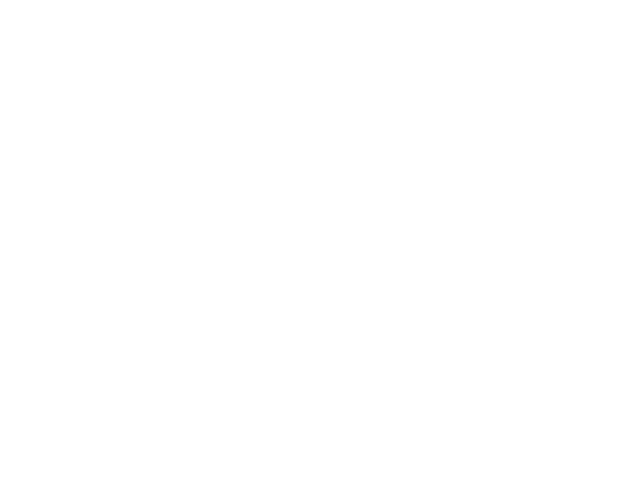

Count:
	Left: 49863	Right: 50137	Collinear: 0


In [18]:
print_categorized(points1cat, DET2X2NP)

---
#### Wyznacznik 2x2 własnej implementacji  (1. zestaw danych)

<IPython.core.display.Javascript object>


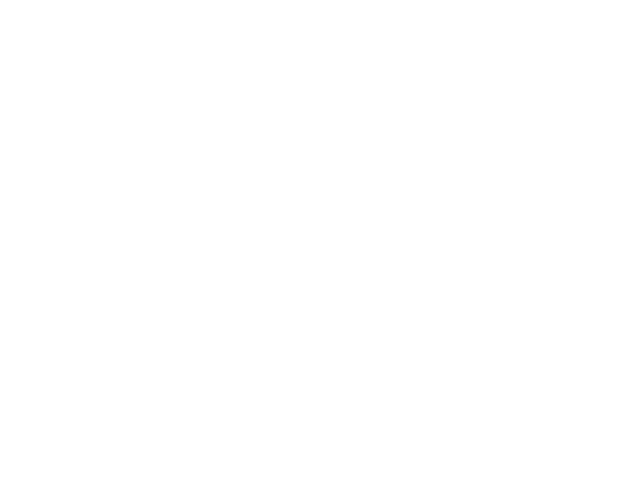

Count:
	Left: 49863	Right: 50137	Collinear: 0


In [19]:
print_categorized(points1cat, DET2X2)

---
#### Wyznacznik 3x3 z biblioteki numpy  (1. zestaw danych)

<IPython.core.display.Javascript object>


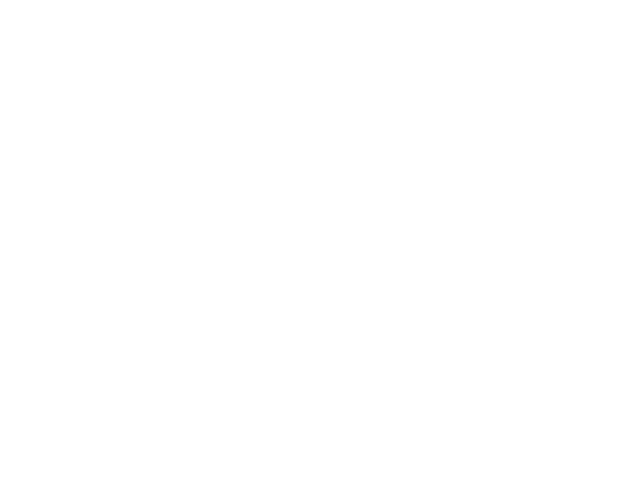

Count:
	Left: 49863	Right: 50137	Collinear: 0


In [20]:
print_categorized(points1cat, DET3X3NP)

---
#### Wyznacznik 3x3 własnej implementacji  (1. zestaw danych)

<IPython.core.display.Javascript object>


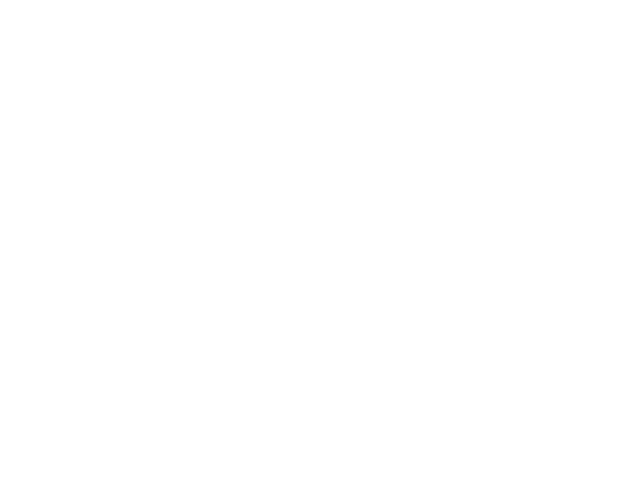

Count:
	Left: 49863	Right: 50137	Collinear: 0


In [21]:
print_categorized(points1cat, DET3X3)

<hr style="border:1px solid gray">

## Porównania wyznaczników dla 2. zestawu danych

---
#### Wyznacznik 2x2 z bilbioteki numpy  (2. zestaw danych)

<IPython.core.display.Javascript object>


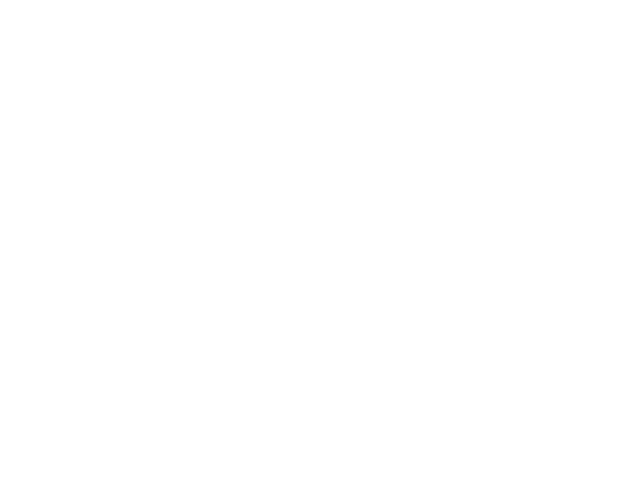

Count:
	Left: 49858	Right: 50142	Collinear: 0


In [22]:
print_categorized(points2cat, DET2X2NP)

---
#### Wyznacznik 2x2 własnej implementacji  (2. zestaw danych)

<IPython.core.display.Javascript object>


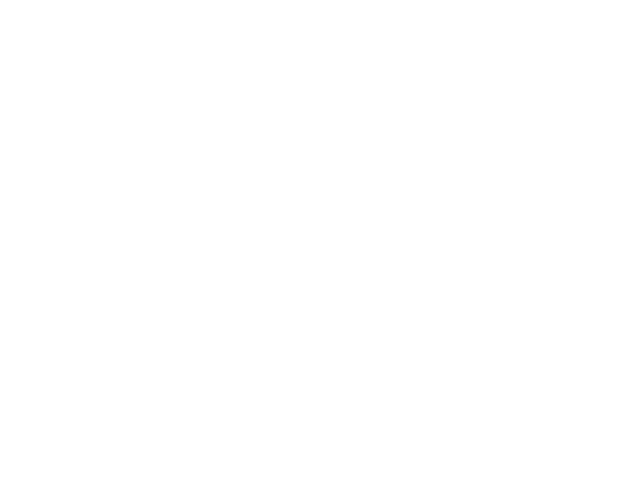

Count:
	Left: 49855	Right: 50138	Collinear: 7


In [23]:
print_categorized(points2cat, DET2X2)

---
#### Wyznacznik 3x3 z biblioteki numpy  (2. zestaw danych)

<IPython.core.display.Javascript object>


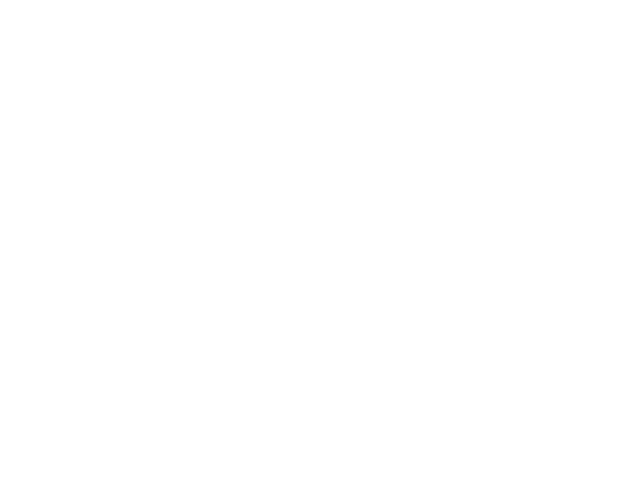

Count:
	Left: 49856	Right: 50144	Collinear: 0


In [24]:
print_categorized(points2cat, DET3X3NP)

---
#### Wyznacznik 3x3 własnej implementacji  (2. zestaw danych)

<IPython.core.display.Javascript object>


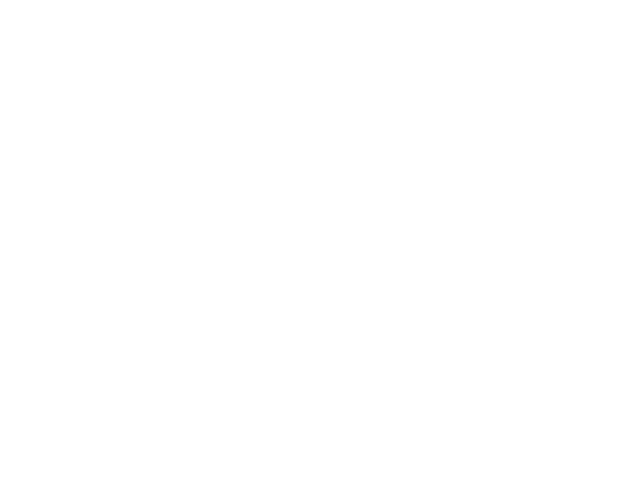

Count:
	Left: 49856	Right: 50144	Collinear: 0


In [25]:
print_categorized(points2cat, DET3X3)

<hr style="border:1px solid gray">

## Porównania wyznaczników dla 3. zestawu danych

---
#### Wyznacznik 2x2 z bilbioteki numpy  (3. zestaw danych)

<IPython.core.display.Javascript object>


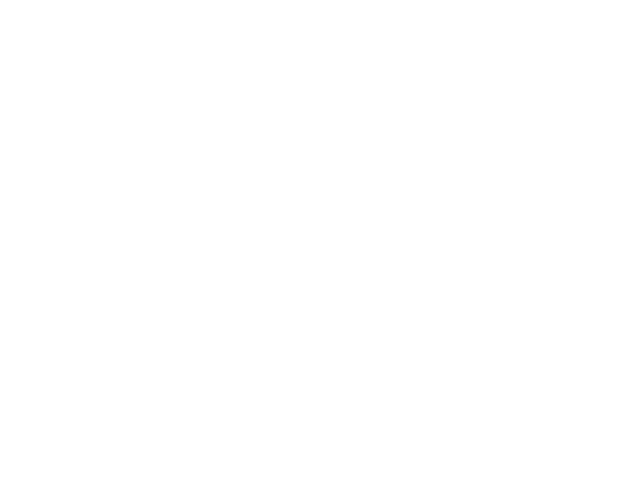

Count:
	Left: 495	Right: 505	Collinear: 0


In [26]:
print_categorized(points3cat, DET2X2NP)

---
#### Wyznacznik 2x2 własnej implementacji  (3. zestaw danych)

<IPython.core.display.Javascript object>


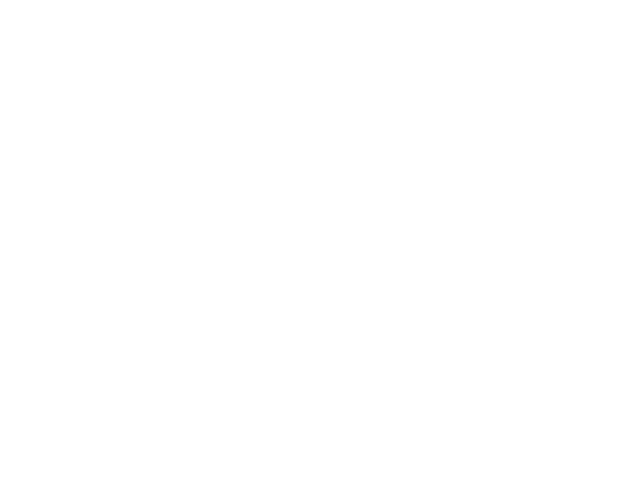

Count:
	Left: 495	Right: 505	Collinear: 0


In [27]:
print_categorized(points3cat, DET2X2)

---
#### Wyznacznik 3x3 z biblioteki numpy  (3. zestaw danych)

<IPython.core.display.Javascript object>


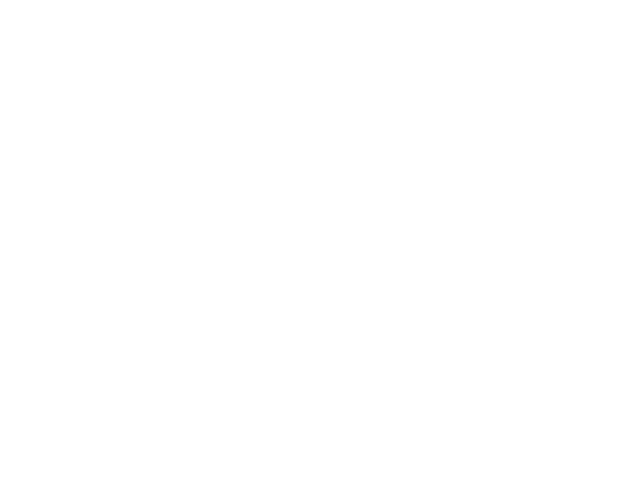

Count:
	Left: 495	Right: 505	Collinear: 0


In [28]:
print_categorized(points3cat, DET3X3NP)

---
#### Wyznacznik 3x3 własnej implementacji  (3. zestaw danych)

<IPython.core.display.Javascript object>


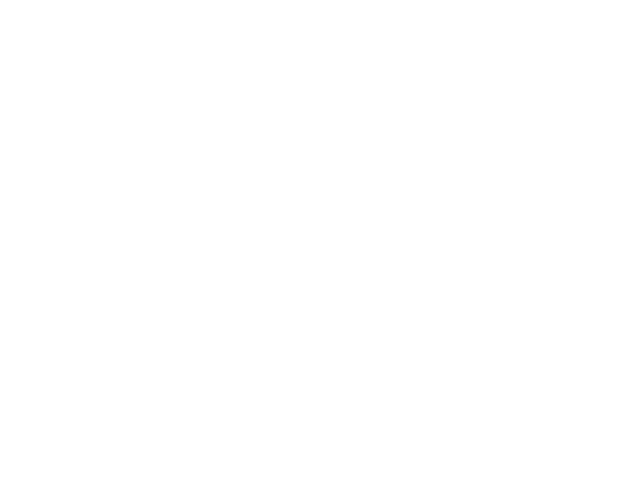

Count:
	Left: 495	Right: 505	Collinear: 0


In [29]:
print_categorized(points3cat, DET3X3)

<hr style="border:1px solid gray">

## Porównania wyznaczników dla 4. zestawu danych

---
#### Wyznacznik 2x2 z bilbioteki numpy  (4. zestaw danych)

<IPython.core.display.Javascript object>


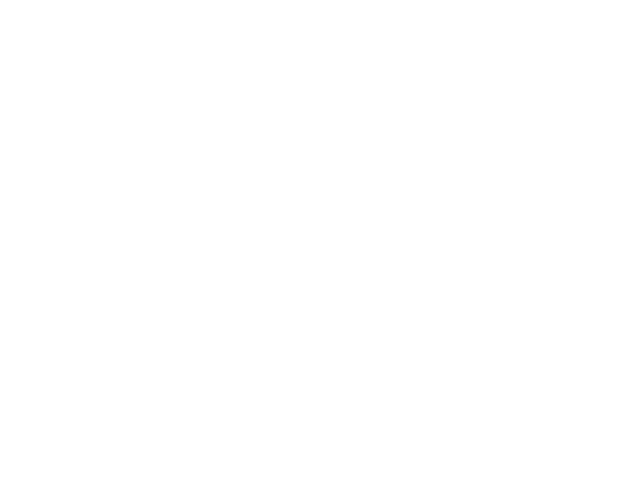

Count:
	Left: 508	Right: 490	Collinear: 2


In [30]:
print_categorized(points4cat, DET2X2NP)

---
#### Wyznacznik 2x2 własnej implementacji  (4. zestaw danych)

<IPython.core.display.Javascript object>


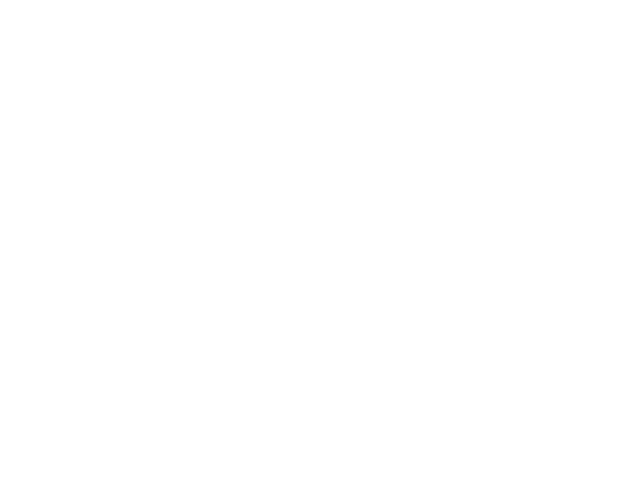

Count:
	Left: 155	Right: 141	Collinear: 704


In [31]:
print_categorized(points4cat, DET2X2)

---
#### Wyznacznik 3x3 z biblioteki numpy  (4. zestaw danych)

<IPython.core.display.Javascript object>


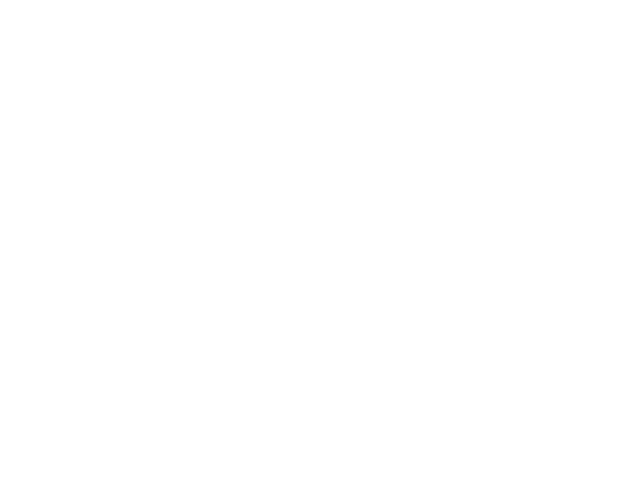

Count:
	Left: 487	Right: 509	Collinear: 4


In [32]:
print_categorized(points4cat, DET3X3NP)

---
#### Wyznacznik 3x3 własnej implementacji  (4. zestaw danych)

<IPython.core.display.Javascript object>


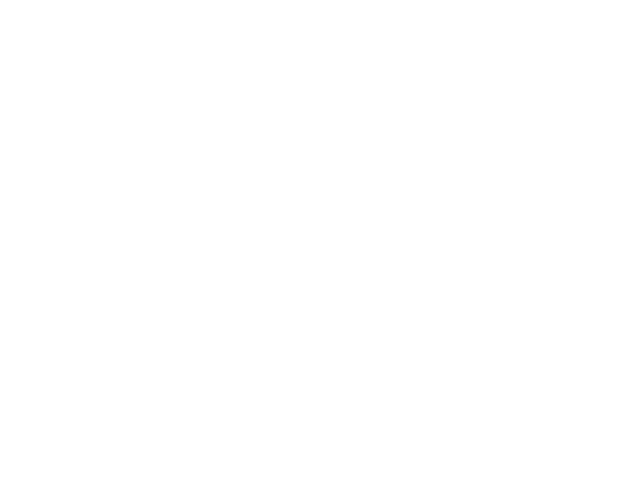

Count:
	Left: 161	Right: 372	Collinear: 467


In [33]:
print_categorized(points4cat, DET3X3)

<hr style="border:1px solid gray">

## Różnice między wyznacznikami

Funkcja <i>difference</i> przyjmuje tablicę skategoryzowanych punktów wraz z interesującymi nas parametrami i zwraca listę punktów których kategoria różni się dla podanych parametrów.

In [34]:
def difference(points, det1, det2, tolerance1=0, tolerance2=0):
    points1assigned = []
    for point in points[det1][tolerance1]['collinear']:
        points1assigned.append((point, 'collinear'))
    for point in points[det1][tolerance1]['left']:
        points1assigned.append((point, 'left'))
    for point in points[det1][tolerance1]['right']:
        points1assigned.append((point, 'right'))
        
    points2assigned = []
    for point in points[det2][tolerance2]['collinear']:
        points2assigned.append((point, 'collinear'))
    for point in points[det2][tolerance2]['left']:
        points2assigned.append((point, 'left'))
    for point in points[det2][tolerance2]['right']:
        points2assigned.append((point, 'right'))
        
    points1assigned.sort()
    points2assigned.sort()
    
    results = []
    for i in range(len(points1assigned)):
        if points1assigned[i][1] != points2assigned[i][1]:
            results.append(points1assigned[i][0])
            
    return results

Funkcja <i>draw_difference</i> pozwala zwizualizować te różnice oraz dodatkowo wyświetla liczbę różnic.

In [35]:
def draw_difference(points, det1, det2, tolerance1=0, tolerance2=0):
    diff = difference(points, det1, det2)
    plot = Plot(points=[PointsCollection(diff)])
    plot.draw()
    print("Differences: " + str(len(diff)))

<hr style="border:1px solid gray">

## Różnice między wyznacznikami dla 1. zestawu danych

---
#### Wyznacznik 2x2 z bilbioteki numpy vs 2x2 własnej implementacji (1. zestaw danych)

<IPython.core.display.Javascript object>


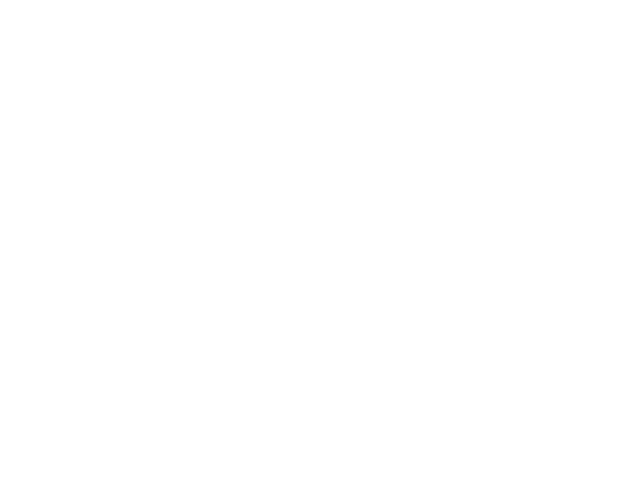

Differences: 0


In [36]:
draw_difference(points1cat, DET2X2NP, DET2X2)

<hr style="border:1px solid gray">

## Różnice między wyznacznikami dla 2. zestawu danych

---
#### Wyznacznik 2x2 z bilbioteki numpy vs 2x2 własnej implementacji (2. zestaw danych)

<IPython.core.display.Javascript object>


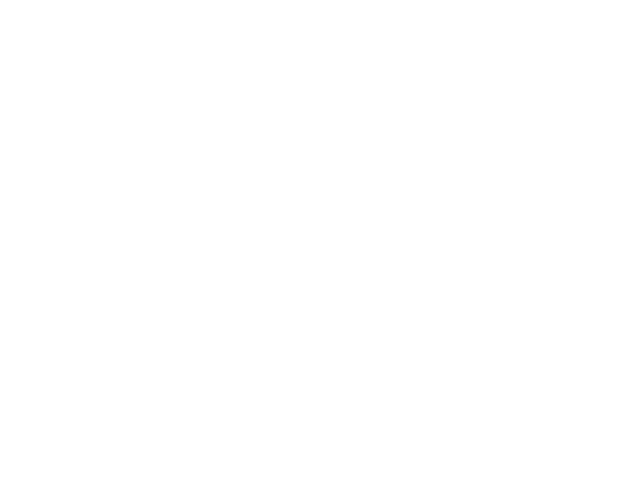

Differences: 7


In [37]:
draw_difference(points2cat, DET2X2NP, DET2X2)

---
#### Wyznacznik 2x2 z bilbioteki numpy vs 3x3 z bilbioteki numpy (2. zestaw danych)

<IPython.core.display.Javascript object>


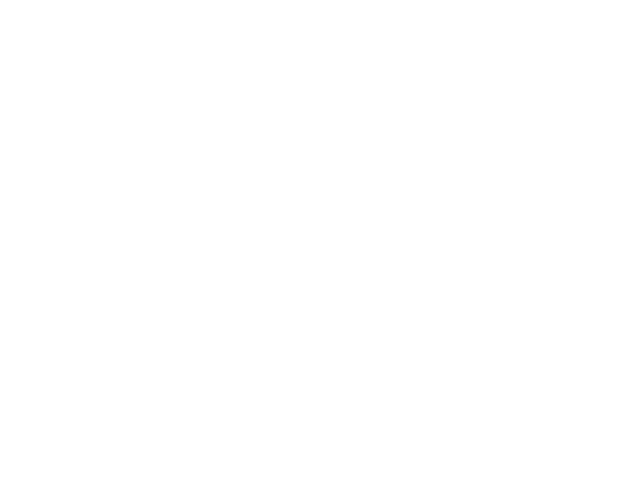

Differences: 2


In [38]:
draw_difference(points2cat, DET2X2NP, DET3X3NP)

<hr style="border:1px solid gray">

## Różnice między wyznacznikami dla 4. zestawu danych

---
#### Wyznacznik 2x2 z bilbioteki numpy vs 2x2 własnej implementacji (4. zestaw danych)

<IPython.core.display.Javascript object>


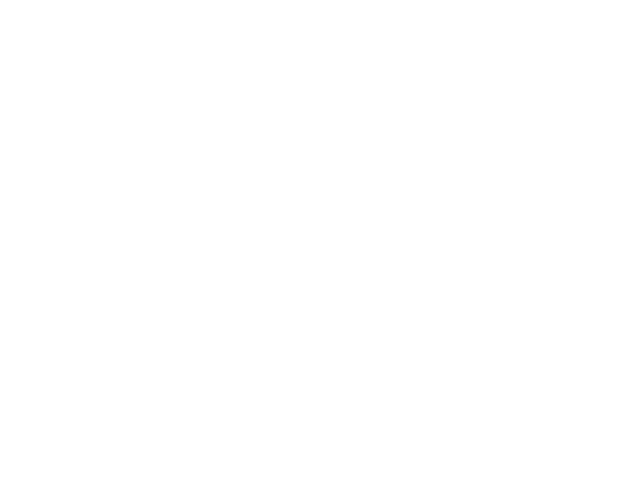

Differences: 721


In [39]:
draw_difference(points4cat, DET2X2NP, DET2X2)

---
#### Wyznacznik 3x3 z bilbioteki numpy vs 3x3 własnej implementacji (4. zestaw danych)

<IPython.core.display.Javascript object>


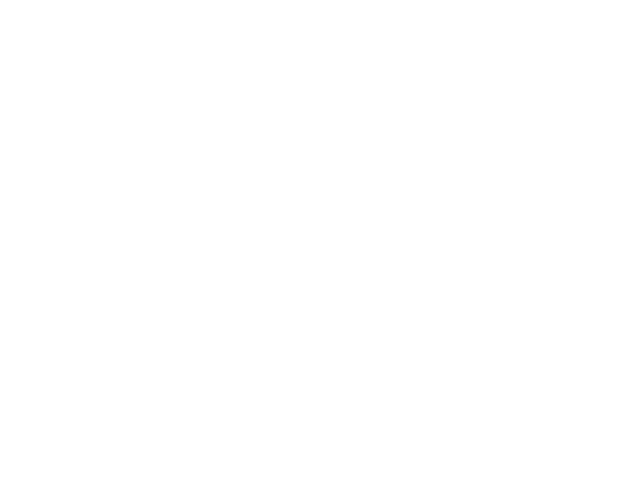

Differences: 594


In [40]:
draw_difference(points4cat, DET3X3NP, DET3X3)

---
#### Wyznacznik 2x2 z bilbioteki numpy vs 3x3 z bilbioteki numpy (4. zestaw danych)

<IPython.core.display.Javascript object>


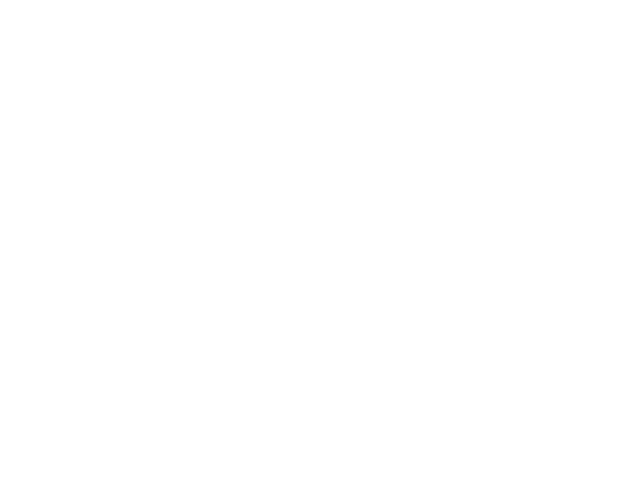

Differences: 482


In [41]:
draw_difference(points4cat, DET2X2NP, DET3X3NP)

---
#### Wyznacznik 2x2 własnej implementacji vs 3x3 własnej implementacji (4. zestaw danych)

<IPython.core.display.Javascript object>


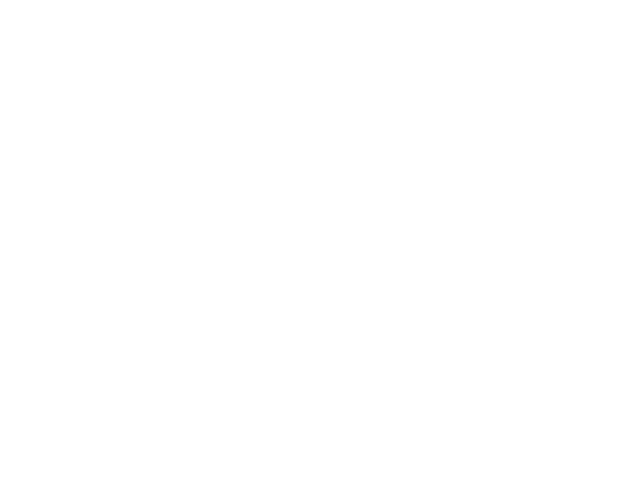

Differences: 653


In [42]:
draw_difference(points4cat, DET2X2, DET3X3)

<hr style="border:1px solid gray">

## Porównanie kombinacji wyznaczników i tolerancji dla zera

Funkcja <i>print_comparison</i> wyświetla interaktywny wykres zawierający wszystkie możliwe kombinacje wyznacznika 
oraz tolerancji dla zera dla danego zestawu punktów.<br>
Ponadto wyświetla ona tabelkę ze zliczonymi ilościami punktów
we wszystkich kategoriach dla wszystkich kombinacji wyznacznika oraz tolerancji dla zera.

In [43]:
dets = ["2x2 numpy", "2x2 własny", "3x3 numpy", "3x3 własny"] # tablica pomocnicza do zamiany numeru wyznacznika na jego nazwę

def print_comparison(points):
    scenes = []
    for i in range(4):
        for j in range(3):
            scenes.append(Scene([PointsCollection(points[i][j]['left'], color='blue'), PointsCollection(points[i][j]['right'], color='green'), PointsCollection(points[i][j]['collinear'], color='red')]))
    plot = Plot(scenes=scenes)
    plot.draw()

    for i in range(4):
        print("[Wyznacznik "+dets[i]+"]=========================================================")
        for j in range(3):
            print("\t[Tolerancja "+str(tolerances[j])+"] |" + " Left: " + str(len(points[i][j]['left']))+ "\tRight: " + str(len(points[i][j]['right'])) + "\tCollinear: "+ str(len(points[i][j]['collinear'])))

<hr style="border:1px solid gray">

## Porównanie kombinacji wyznaczników i tolerancji dla 1. zestawu danych

<IPython.core.display.Javascript object>


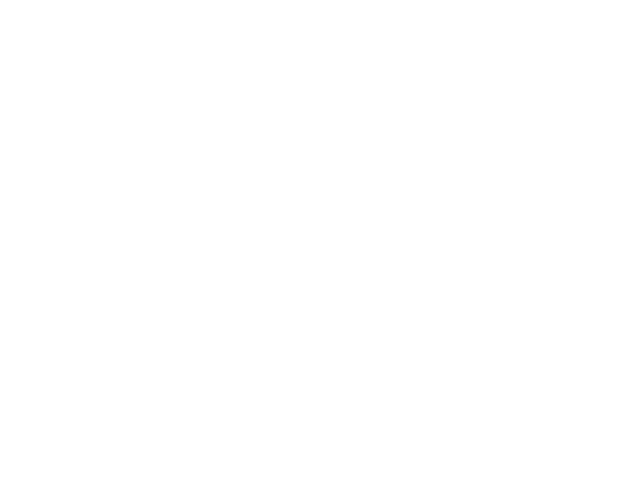

[Wyznacznik 2x2 numpy]=========================================================
	[Tolerancja 1e-17] | Left: 49863	Right: 50137	Collinear: 0
	[Tolerancja 1e-13] | Left: 49863	Right: 50137	Collinear: 0
	[Tolerancja 1e-09] | Left: 49863	Right: 50137	Collinear: 0
[Wyznacznik 2x2 własny]=========================================================
	[Tolerancja 1e-17] | Left: 49863	Right: 50137	Collinear: 0
	[Tolerancja 1e-13] | Left: 49863	Right: 50137	Collinear: 0
	[Tolerancja 1e-09] | Left: 49863	Right: 50137	Collinear: 0
[Wyznacznik 3x3 numpy]=========================================================
	[Tolerancja 1e-17] | Left: 49863	Right: 50137	Collinear: 0
	[Tolerancja 1e-13] | Left: 49863	Right: 50137	Collinear: 0
	[Tolerancja 1e-09] | Left: 49863	Right: 50137	Collinear: 0
[Wyznacznik 3x3 własny]=========================================================
	[Tolerancja 1e-17] | Left: 49863	Right: 50137	Collinear: 0
	[Tolerancja 1e-13] | Left: 49863	Right: 50137	Collinear: 0
	[Tolerancja 1e-09

In [44]:
print_comparison(points1cat)

<hr style="border:1px solid gray">

## Porównanie kombinacji wyznaczników i tolerancji dla 2. zestawu danych

<IPython.core.display.Javascript object>


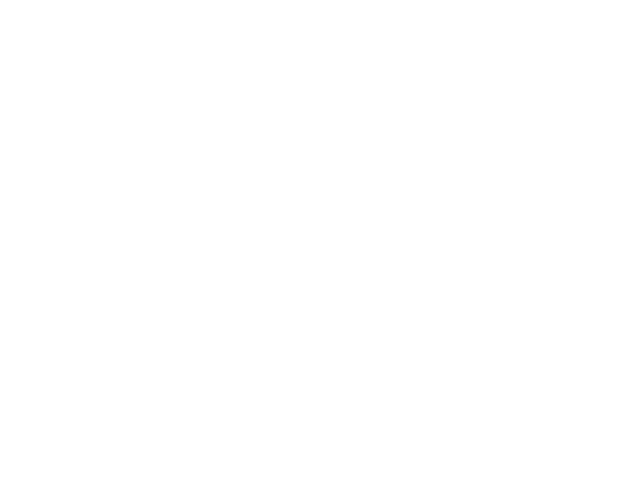

[Wyznacznik 2x2 numpy]=========================================================
	[Tolerancja 1e-17] | Left: 49858	Right: 50142	Collinear: 0
	[Tolerancja 1e-13] | Left: 49858	Right: 50142	Collinear: 0
	[Tolerancja 1e-09] | Left: 49858	Right: 50142	Collinear: 0
[Wyznacznik 2x2 własny]=========================================================
	[Tolerancja 1e-17] | Left: 49855	Right: 50138	Collinear: 7
	[Tolerancja 1e-13] | Left: 49855	Right: 50138	Collinear: 7
	[Tolerancja 1e-09] | Left: 49855	Right: 50138	Collinear: 7
[Wyznacznik 3x3 numpy]=========================================================
	[Tolerancja 1e-17] | Left: 49856	Right: 50144	Collinear: 0
	[Tolerancja 1e-13] | Left: 49856	Right: 50144	Collinear: 0
	[Tolerancja 1e-09] | Left: 49856	Right: 50144	Collinear: 0
[Wyznacznik 3x3 własny]=========================================================
	[Tolerancja 1e-17] | Left: 49856	Right: 50144	Collinear: 0
	[Tolerancja 1e-13] | Left: 49856	Right: 50144	Collinear: 0
	[Tolerancja 1e-09

In [45]:
print_comparison(points2cat)

<hr style="border:1px solid gray">

## Porównanie kombinacji wyznaczników i tolerancji dla 3. zestawu danych

<IPython.core.display.Javascript object>


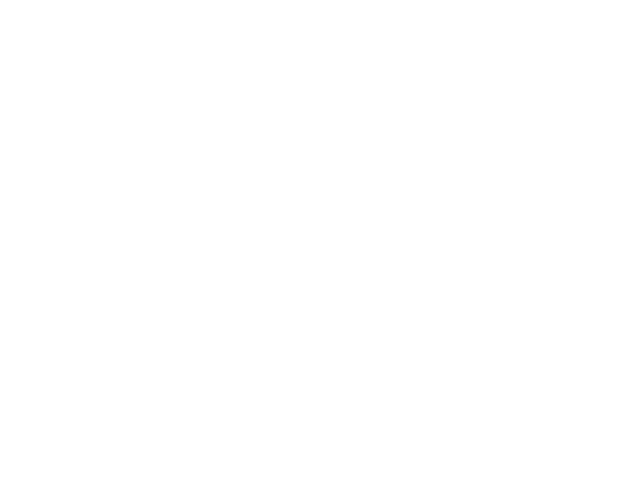

[Wyznacznik 2x2 numpy]=========================================================
	[Tolerancja 1e-17] | Left: 495	Right: 505	Collinear: 0
	[Tolerancja 1e-13] | Left: 495	Right: 505	Collinear: 0
	[Tolerancja 1e-09] | Left: 495	Right: 505	Collinear: 0
[Wyznacznik 2x2 własny]=========================================================
	[Tolerancja 1e-17] | Left: 495	Right: 505	Collinear: 0
	[Tolerancja 1e-13] | Left: 495	Right: 505	Collinear: 0
	[Tolerancja 1e-09] | Left: 495	Right: 505	Collinear: 0
[Wyznacznik 3x3 numpy]=========================================================
	[Tolerancja 1e-17] | Left: 495	Right: 505	Collinear: 0
	[Tolerancja 1e-13] | Left: 495	Right: 505	Collinear: 0
	[Tolerancja 1e-09] | Left: 495	Right: 505	Collinear: 0
[Wyznacznik 3x3 własny]=========================================================
	[Tolerancja 1e-17] | Left: 495	Right: 505	Collinear: 0
	[Tolerancja 1e-13] | Left: 495	Right: 505	Collinear: 0
	[Tolerancja 1e-09] | Left: 495	Right: 505	Collinear: 0


In [46]:
print_comparison(points3cat)

<hr style="border:1px solid gray">

## Porównanie kombinacji wyznaczników i tolerancji dla 4. zestawu danych

<IPython.core.display.Javascript object>


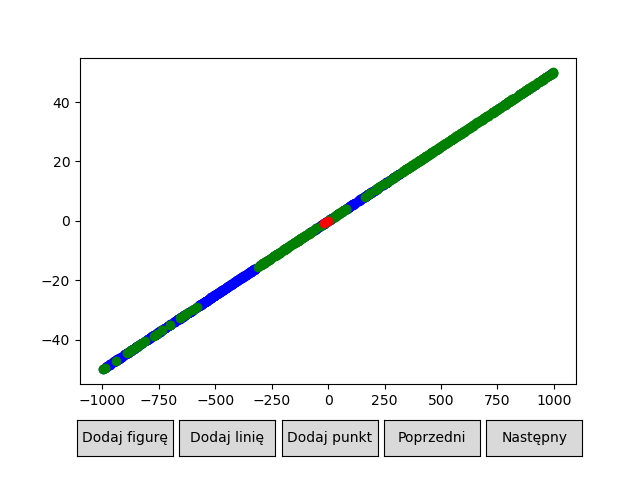

[Wyznacznik 2x2 numpy]=========================================================
	[Tolerancja 1e-17] | Left: 508	Right: 490	Collinear: 2
	[Tolerancja 1e-13] | Left: 384	Right: 331	Collinear: 285
	[Tolerancja 1e-09] | Left: 0	Right: 0	Collinear: 1000
[Wyznacznik 2x2 własny]=========================================================
	[Tolerancja 1e-17] | Left: 155	Right: 141	Collinear: 704
	[Tolerancja 1e-13] | Left: 139	Right: 124	Collinear: 737
	[Tolerancja 1e-09] | Left: 0	Right: 0	Collinear: 1000
[Wyznacznik 3x3 numpy]=========================================================
	[Tolerancja 1e-17] | Left: 487	Right: 509	Collinear: 4
	[Tolerancja 1e-13] | Left: 0	Right: 0	Collinear: 1000
	[Tolerancja 1e-09] | Left: 0	Right: 0	Collinear: 1000
[Wyznacznik 3x3 własny]=========================================================
	[Tolerancja 1e-17] | Left: 161	Right: 372	Collinear: 467
	[Tolerancja 1e-13] | Left: 0	Right: 0	Collinear: 1000
	[Tolerancja 1e-09] | Left: 0	Right: 0	Collinear: 1000


In [47]:
print_comparison(points4cat)